# Init

In [1]:
%cd ..

import matplotlib.pyplot as plt
import re
import numpy as np
from collections import defaultdict
import os

def plot_psnr_analysis(resolution, snr=30, seeds=[42], types=["linear", "neural", "mlp", "conv", "twoconv", "zeroshot"]):
    """
    Plot PSNR analysis for multiple seeds and aligner types.
    
    Args:
        snr: Signal-to-noise ratio value
        seeds: List of seed values to analyze
        types: List of aligner types to compare
    """

    type_name_dict = {
        "linear": "linear_closed",
        "neural": "linear_adam",
        "mlp": "mlp",
        "conv": "linear_conv",
        "twoconv": "ml_conv",
        "zeroshot": "zeroshot"
    }
    
    # Dictionary to store data for each aligner type across all seeds
    aligner_data = defaultdict(lambda: defaultdict(list))  # {aligner_type: {sample_count: [psnr_values]}}
    
    # Lists to store baseline values across seeds
    unaligned_values = []
    aligned_values = []
    zeroshot_values = []
    
    # Process each seed
    for seed in seeds:
        # Read baseline values for this seed
        lines_path = f'alignment/logs_{resolution}/lines_snr_{snr}_seed_{seed}.txt'
        
        if os.path.exists(lines_path):
            with open(lines_path, 'r') as file:
                lines = file.readlines()
                unaligned_values.append(float(lines[0].split()[1]))
                aligned_values.append(float(lines[1].split()[1]))
                zeroshot_values.append(float(lines[2].split()[1]))
        else:
            print(f"Warning: {lines_path} not found, skipping seed {seed}")
            continue
        
        # Process each aligner type for this seed
        for aligner_type in types:
            log_path = f'alignment/logs_{resolution}/aligner_{aligner_type}_snr_{snr}_seed_{seed}.txt'
            
            if os.path.exists(log_path):
                with open(log_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                
                # Extract sample counts and PSNR values
                matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', content)
                
                for sample_str, psnr_str in matches:
                    sample_count = int(sample_str)
                    psnr_value = float(psnr_str)
                    aligner_data[aligner_type][sample_count].append(psnr_value)
            else:
                print(f"Warning: {log_path} not found")
    
    # Calculate means for baseline values
    unaligned_mean = np.mean(unaligned_values) if unaligned_values else 0
    aligned_mean = np.mean(aligned_values) if aligned_values else 0
    zeroshot_mean = np.mean(zeroshot_values) if zeroshot_values else 0
    
    # Create the plot
    plt.figure(figsize=(10, 5))
    
    # Plot each aligner type
    for aligner_type in types:
        if aligner_type in aligner_data:
            # Get all sample counts and sort them
            sample_counts = sorted(aligner_data[aligner_type].keys())
            mean_psnr = []
            std_psnr = []
            
            for sample_count in sample_counts:
                psnr_values = aligner_data[aligner_type][sample_count]
                mean_psnr.append(np.mean(psnr_values))
                std_psnr.append(np.std(psnr_values))
            
            # Convert to numpy arrays for easier manipulation
            sample_counts = np.array(sample_counts)
            mean_psnr = np.array(mean_psnr)
            std_psnr = np.array(std_psnr)
            
            # Plot mean line
            line = plt.plot(sample_counts, mean_psnr, marker='o', label=f'{type_name_dict[aligner_type]}')[0]
            
            # Fill area representing standard deviation
            plt.fill_between(sample_counts, 
                           mean_psnr - std_psnr, 
                           mean_psnr + std_psnr, 
                           alpha=0.2, 
                           color=line.get_color())
    
    # Plot baseline horizontal lines
    if unaligned_values:
        plt.axhline(y=unaligned_mean, color='red', linestyle='--', linewidth=1, 
                   label=f'unaligned')
    if aligned_values:
        plt.axhline(y=aligned_mean, color='green', linestyle='--', linewidth=1, 
                   label=f'no_mismatch')
    if zeroshot_values:
        plt.axhline(y=zeroshot_mean, color='blue', linestyle='--', linewidth=1, 
                   label=f'zeroshot_full')
    
    plt.title(f"SNR {snr} - Resolution {resolution}x{resolution} - Mean across {len(seeds)} seeds")
    plt.xlabel("Number of Semantic Pilots")
    plt.ylabel("PSNR (dB)")
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    os.makedirs('output', exist_ok=True)
    
    filename = f"psnr_vs_pilots_snr_{snr}"
    
    # Save in both formats
    pdf_path = os.path.join('output', f"{filename}.pdf")
    png_path = os.path.join('output', f"{filename}.png")
    
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
    
    print(f"Plots saved as:")
    print(f"  PDF: {pdf_path}")
    print(f"  PNG: {png_path}")

    plt.show()

/home/lorenzo/repos/Deep-JSCC-PyTorch


# Exec

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_30.pdf
  PNG: output/psnr_vs_pilots_snr_30.png


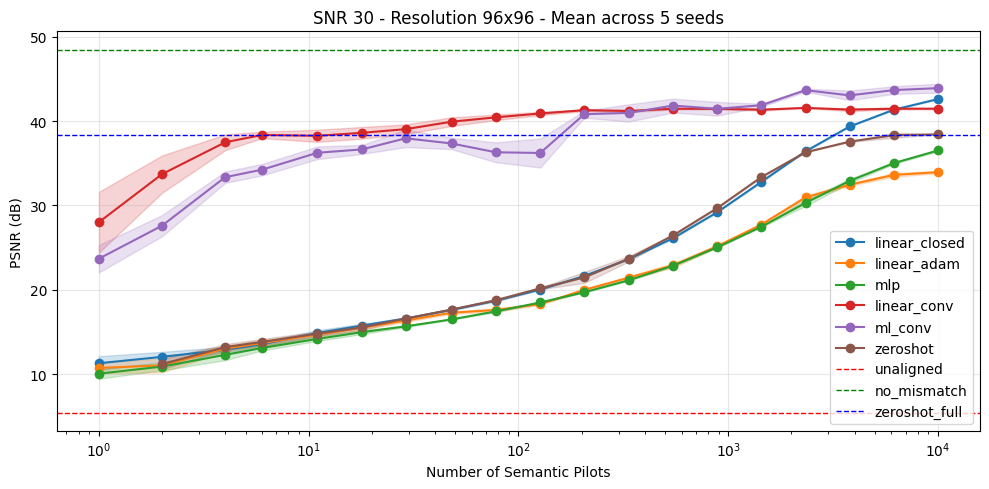

In [2]:
plot_psnr_analysis(resolution=96, snr=30, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_20.pdf
  PNG: output/psnr_vs_pilots_snr_20.png


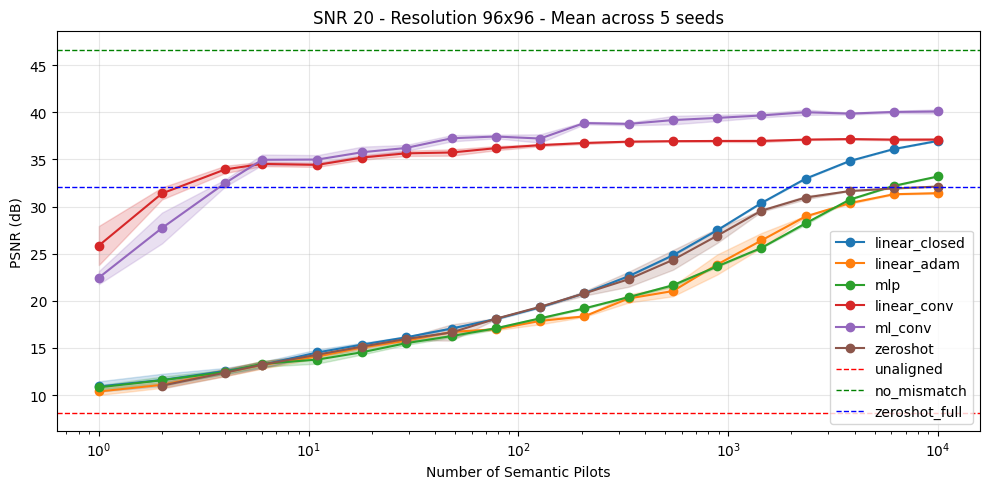

In [3]:
plot_psnr_analysis(resolution=96, snr=20, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_10.pdf
  PNG: output/psnr_vs_pilots_snr_10.png


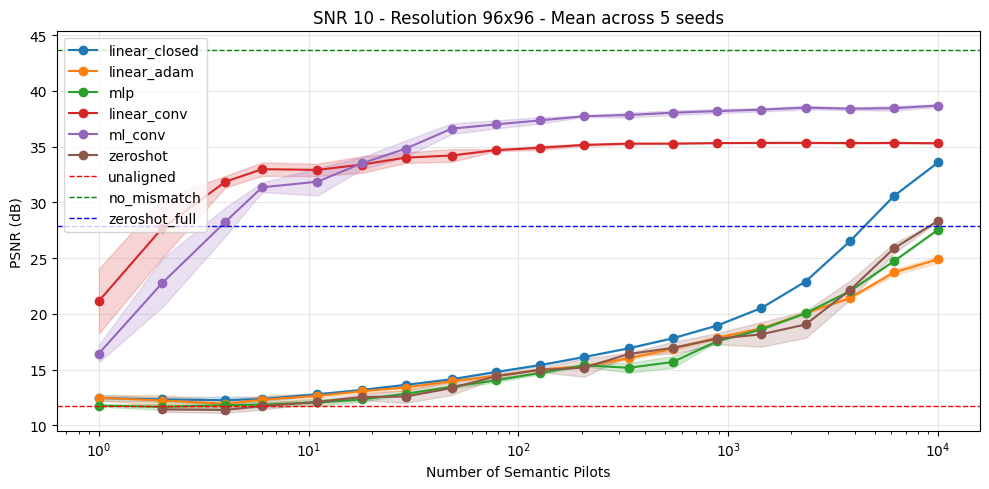

In [4]:
plot_psnr_analysis(resolution=96, snr=10, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_0.pdf
  PNG: output/psnr_vs_pilots_snr_0.png


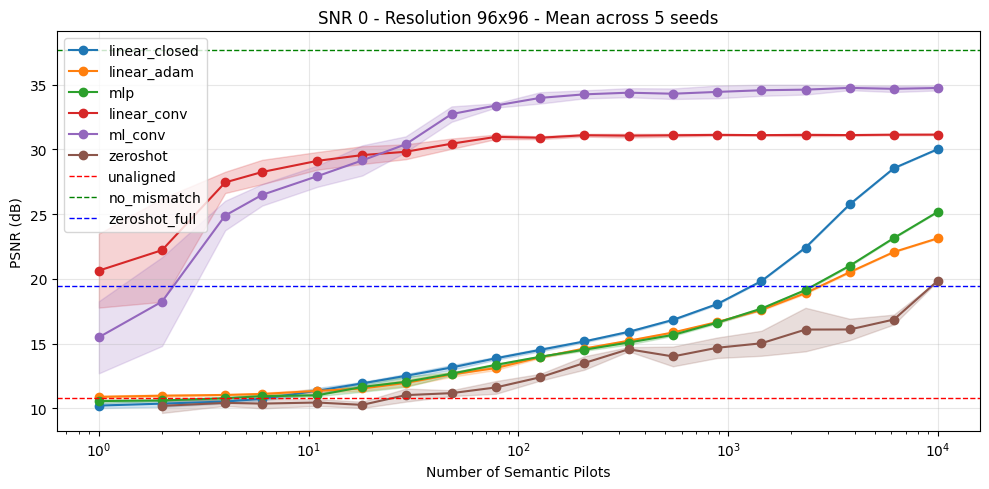

In [5]:
plot_psnr_analysis(resolution=96, snr=0, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_-10.pdf
  PNG: output/psnr_vs_pilots_snr_-10.png


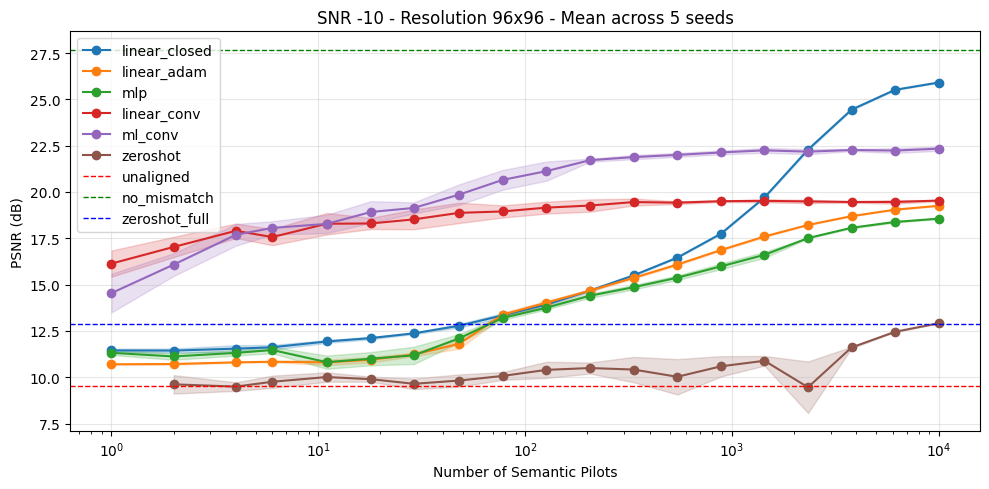

In [6]:
plot_psnr_analysis(resolution=96, snr=-10, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_-20.pdf
  PNG: output/psnr_vs_pilots_snr_-20.png


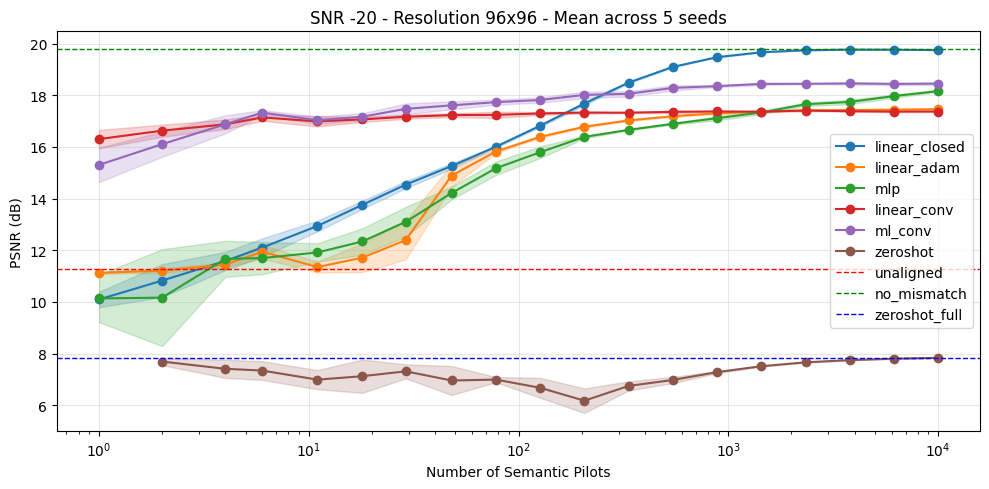

In [7]:
plot_psnr_analysis(resolution=96, snr=-20, seeds=[42, 43, 44, 45, 46])